In [2]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [39]:
PATH = '../downloads/runs/2023-10-22/yolo_v1_model.pt'
DATASET_PATH = '../downloads/TACO/data'
anns_file_path = DATASET_PATH + '/' + 'annotations.json'

In [40]:
model = torch.load(PATH, map_location=torch.device('cpu'))

In [41]:
from model import numel

print('Number of parameters: %d' % numel(model))

Number of parameters: 267902427


In [42]:
IMAGE_SIZE = 448

data_preprocess = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

In [43]:
from utils import (
    plot_image,
    cellboxes_to_boxes,
    non_max_suppression,
)
from taco_dataset import CoCoDatasetForYOLO

dataset = CoCoDatasetForYOLO(
    root=DATASET_PATH,
    annFile=anns_file_path,
    transform=data_preprocess,
    C=1
)

loading annotations into memory...
Done (t=1.24s)
creating index...
index created!


In [61]:
idx = 44
data = dataset[idx]

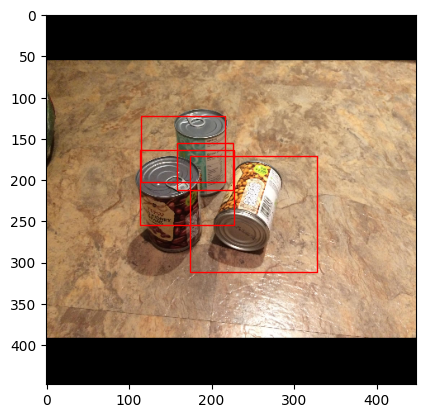

In [62]:
import torchvision.transforms as transforms
pred = model(data[0].unsqueeze(0))
pred = cellboxes_to_boxes(pred, S=7, B=2, C=1)
pred = non_max_suppression(pred[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

transform = transforms.ToPILImage()
plot_image(transform(data[0]), pred)

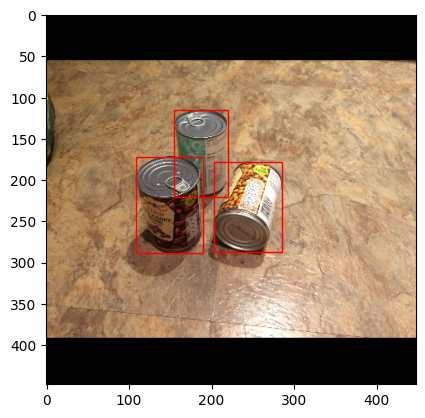

In [63]:
bboxes = cellboxes_to_boxes(torch.tensor([data[1].tolist()]), S=7, B=2, C=1)
bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

transform = transforms.ToPILImage()
plot_image(transform(data[0]), bboxes)

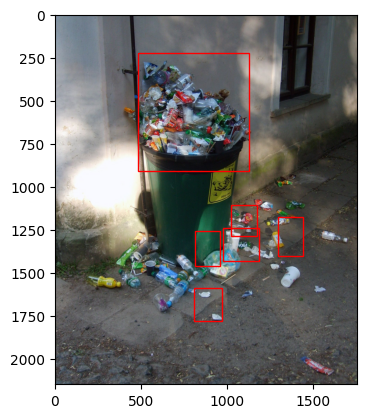

In [64]:
from PIL import Image
import numpy as np
SAMPLE_IMAGE_DIR = '../downloads/sample_image.jpg'

sample_image = Image.open(SAMPLE_IMAGE_DIR)
preprocessed_image = data_preprocess(image=np.array(sample_image), bboxes=[])["image"].unsqueeze(0)

sample_image_pred = model(preprocessed_image)
sample_image_pred = cellboxes_to_boxes(sample_image_pred, S=7, B=2, C=1)
sample_image_pred = non_max_suppression(sample_image_pred[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

plot_image(sample_image, sample_image_pred)